In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# 1. Importowanie danych z zadania Titanic
def load_data():
    train_df = pd.read_csv('/data/titanic/train.csv')
    return train_df
    print(train_df)

# 2. Wyodrębnianie cech i normalizacja
def preprocess_data(df):
    features = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']].copy()
    
    # Normalizacja cech do przedziału <-1, 1>
    scaler = MinMaxScaler(feature_range=(-1, 1))
    features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = scaler.fit_transform(features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
    
    # Normalizacja kategorii Sex
    label_encoder = LabelEncoder()
    features['Sex'] = label_encoder.fit_transform(features['Sex']) * 2 - 1  # 'female' -> -1, 'male' -> 1

    return features

# 3. Funkcja główna
def main():
    df = load_data()
    processed_data = preprocess_data(df)
    print(processed_data.head())
    print(min(processed_data["Parch"]))
    print(max(processed_data["Parch"]))

if __name__ == '__main__':
    main()


   Pclass       Age  SibSp  Parch      Fare  Sex
0     1.0 -0.457653  -0.75   -1.0 -0.971698    1
1    -1.0 -0.055542  -0.75   -1.0 -0.721729   -1
2     1.0 -0.357125  -1.00   -1.0 -0.969063   -1
3    -1.0 -0.130937  -0.75   -1.0 -0.792711   -1
4     1.0 -0.130937  -1.00   -1.0 -0.968575    1
-1.0
1.0


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5847 - loss: 0.6633 - val_accuracy: 0.5922 - val_loss: 0.6066
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6674 - loss: 0.5926 - val_accuracy: 0.7654 - val_loss: 0.5487
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7237 - loss: 0.5703 - val_accuracy: 0.7821 - val_loss: 0.5001
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8263 - loss: 0.4841 - val_accuracy: 0.7821 - val_loss: 0.4775
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8107 - loss: 0.4729 - val_accuracy: 0.7821 - val_loss: 0.4666
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7889 - loss: 0.5021 - val_accuracy: 0.7821 - val_loss: 0.4608
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8063 - loss: 0.4808 - val_accuracy: 0.7877 - val_loss: 0.4519
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7897 - loss: 0.4763 - val_accuracy: 0.7933 - 

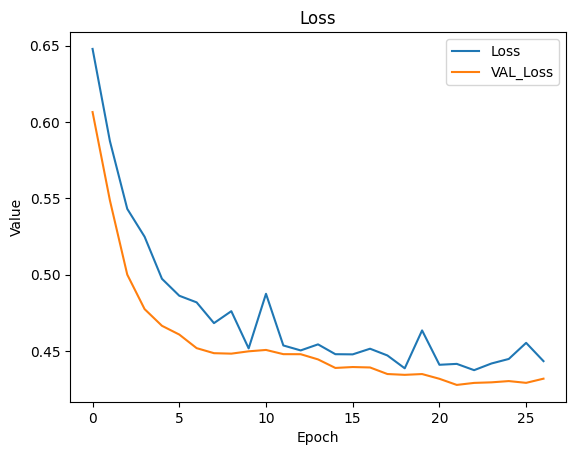

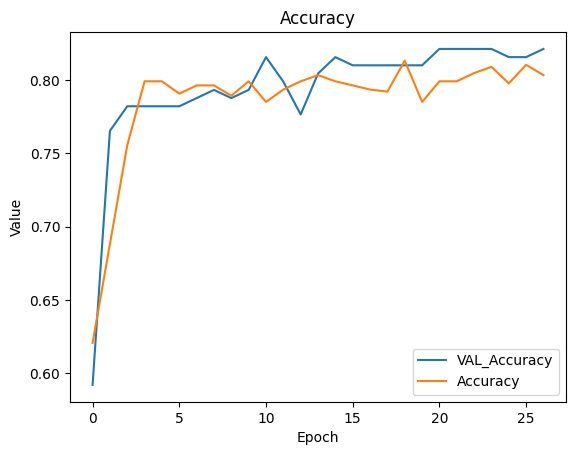

Najlepsza dokładność walidacyjna: 0.8212290406227112 na epokę 20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[0.11040772]
 [0.39202073]
 [0.11480457]
 [0.13247137]
 [0.5382228 ]
 [0.18244949]
 [0.5613962 ]
 [0.21790989]
 [0.6224084 ]
 [0.1514101 ]
 [0.13232617]
 [0.25794494]
 [0.9785758 ]
 [0.11728022]
 [0.9783847 ]
 [0.9203563 ]
 [0.17315866]
 [0.15347195]
 [0.5386703 ]
 [0.46019787]
 [0.22837456]
 [0.21409868]
 [0.9818375 ]
 [0.43775618]
 [0.9795747 ]
 [0.08213007]
 [0.98055553]
 [0.14790447]
 [0.28049284]
 [0.13033803]]


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [2]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from numpy import float32
# 1. Importowanie danych z zadania Titanic
def load_data():
    train_df = pd.read_csv('/kaggle/input/titanic-dataset/train.csv')
    test_df = pd.read_csv('/kaggle/input/titanic-dataset/test.csv')
    return train_df, test_df
def test_preprocess_data(df):
    features = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']].copy()
     # Zakładamy, że przewidujemy czy ktoś przeżył
    features['Age'] = features['Age'].fillna(features['Age'].median())


    # Normalizacja cech do przedziału <-1, 1>
    scaler = MinMaxScaler(feature_range=(-1, 1))
    features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = scaler.fit_transform(features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
    
    # Normalizacja kategorii Sex
    label_encoder = LabelEncoder()
    features['Sex'] = label_encoder.fit_transform(features['Sex']) * 2 - 1  # 'female' -> -1, 'male' -> 1

    return features

# 2. Wyodrębnianie cech i normalizacja
def preprocess_data(df):
    features = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']].copy()
    labels = df['Survived'].copy()  # Zakładamy, że przewidujemy czy ktoś przeżył
    features['Age'] = features['Age'].fillna(features['Age'].median())


    # Normalizacja cech do przedziału <-1, 1>
    scaler = MinMaxScaler(feature_range=(-1, 1))
    features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = scaler.fit_transform(features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
    
    # Normalizacja kategorii Sex
    label_encoder = LabelEncoder()
    features['Sex'] = label_encoder.fit_transform(features['Sex']) * 2 - 1  # 'female' -> -1, 'male' -> 1

    return features, labels

# 3. Konwersja do macierzy NumPy
def convert_to_numpy(features, labels):
    X = features.to_numpy()  # Zamiana DataFrame na macierz NumPy
    y = labels.to_numpy()
    return X, y

# 4. Tworzenie modelu Keras
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(6,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Wynik binarny (czy przeżył, czy nie)
    ])
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 5. Funkcja główna
def main():
    df_t, df_test = load_data()
    features_test = test_preprocess_data(df_test)
    datatest = features_test.to_numpy()
    features, labels = preprocess_data(df_t)
    X, y = convert_to_numpy(features, labels)

    # Podział na zestawy treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tworzenie i trenowanie modelu
    model = create_model()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=5, 
                                                      restore_best_weights=True)
    history = model.fit(X_train,
                        y_train, 
                        epochs=100,
                        batch_size=32, 
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])

    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    
   # val_loss = val_loss[5:]
   # val_accuracy = val_accuracy[5:]
    # Tworzenie wykresu
    plt.plot(loss, label='Loss')
    plt.plot(val_loss, label='VAL_Loss')
    

    # Dodanie etykiet i tytułu
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Loss')
    plt.legend()

    # Wyświetlenie wykresu
    plt.show()
    plt.clf()
    plt.plot(val_accuracy, label='VAL_Accuracy')
    plt.plot(accuracy, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Accuracy')
    plt.legend()

    # Wyświetlenie wykresu
    plt.show()
    
    best_epoch = np.argmax(val_accuracy)  # Zwraca indeks największej wartości


    print(f'Najlepsza dokładność walidacyjna: {max(val_accuracy)} na epokę {best_epoch}')
    datatest = datatest.astype(float32)
    predictions = model.predict(datatest)
    print(predictions[:30])
    predicted_classes = (predictions > 0.5).astype(int)  # 1 dla prawdopodobieństw > 0.5, 0 dla pozostałych
    predicted_classes = predicted_classes * 2 - 1  # 0 -> -1, 1 -> 1
    # Przygotowanie DataFrame do zapisania
    submission_df = pd.DataFrame({
        'PassengerId': df.loc[X_test.index, 'PassengerId'],  # Zakładając, że masz PassengerId w danych testowych
        'Survived': predicted_classes.flatten()  # Flatten, aby upewnić się, że jest w formie jednowymiarowej
    })

    # Zapis do pliku CSV
    submission_df.to_csv('submission.csv', index=False)

if __name__ == '__main__':
    main()


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4680 - loss: 0.7148 - val_accuracy: 0.7654 - val_loss: 0.6015
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7215 - loss: 0.6059 - val_accuracy: 0.7654 - val_loss: 0.5390
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7519 - loss: 0.5587 - val_accuracy: 0.7821 - val_loss: 0.4896
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7631 - loss: 0.5323 - val_accuracy: 0.7821 - val_loss: 0.4655
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7770 - loss: 0.5131 - val_accuracy: 0.7821 - val_loss: 0.4565
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8079 - loss: 0.4602 - val_accuracy: 0.7877 - val_loss: 0.4479
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8100 - loss: 0.4798 - val_accuracy: 0.7989 - val_loss: 0.4465
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7865 - loss: 0.4748 - val_accuracy: 0.7989 - 

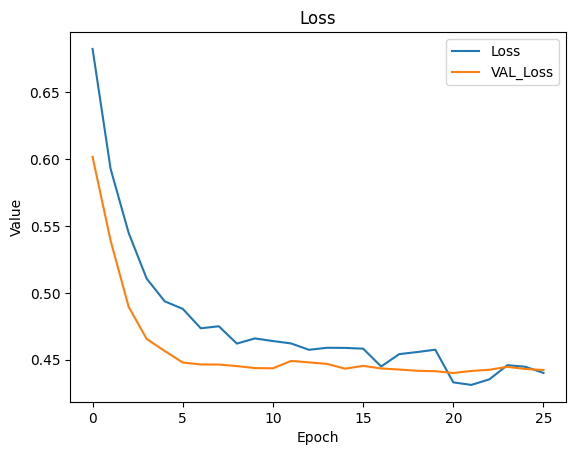

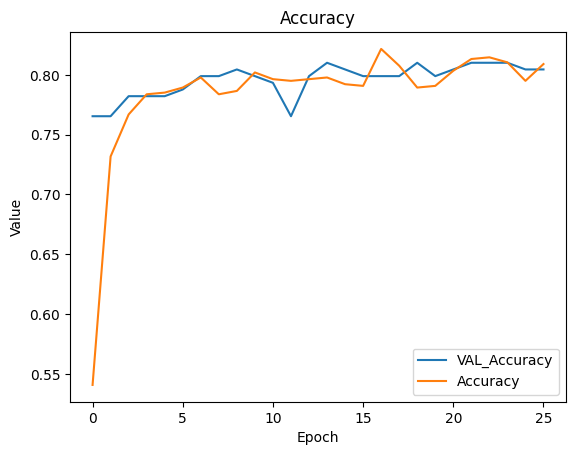

Najlepsza dokładność walidacyjna: 0.8100558519363403 na epokę 13
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [17]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from numpy import float32

# 1. Importowanie danych z zadania Titanic
def load_data():
    train_df = pd.read_csv('/kaggle/input/titanic-dataset/train.csv')
    test_df = pd.read_csv('/kaggle/input/titanic-dataset/test.csv')
    return train_df, test_df

# Funkcja do przetwarzania danych testowych
def test_preprocess_data(df):
    features = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']].copy()
    features['Age'] = features['Age'].fillna(features['Age'].median())

    # Normalizacja cech do przedziału <-1, 1>
    scaler = MinMaxScaler(feature_range=(-1, 1))
    features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = scaler.fit_transform(features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
    
    # Normalizacja kategorii Sex
    label_encoder = LabelEncoder()
    features['Sex'] = label_encoder.fit_transform(features['Sex']) * 2 - 1  # 'female' -> -1, 'male' -> 1

    return features

# 2. Wyodrębnianie cech i normalizacja
def preprocess_data(df):
    features = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']].copy()
    labels = df['Survived'].copy()  # Zakładamy, że przewidujemy czy ktoś przeżył
    features['Age'] = features['Age'].fillna(features['Age'].median())

    # Normalizacja cech do przedziału <-1, 1>
    scaler = MinMaxScaler(feature_range=(-1, 1))
    features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = scaler.fit_transform(features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
    
    # Normalizacja kategorii Sex
    label_encoder = LabelEncoder()
    features['Sex'] = label_encoder.fit_transform(features['Sex']) * 2 - 1  # 'female' -> -1, 'male' -> 1

    return features, labels

# 3. Konwersja do macierzy NumPy
def convert_to_numpy(features, labels):
    X = features.to_numpy()  # Zamiana DataFrame na macierz NumPy
    y = labels.to_numpy()
    return X, y

# 4. Tworzenie modelu Keras
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(6,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Wynik binarny (czy przeżył, czy nie)
    ])
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 5. Funkcja główna
def main():
    df_t, df_test = load_data()
    features_test = test_preprocess_data(df_test)
    datatest = features_test.to_numpy()
    features, labels = preprocess_data(df_t)
    X, y = convert_to_numpy(features, labels)

    # Podział na zestawy treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tworzenie i trenowanie modelu
    model = create_model()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=5, 
                                                      restore_best_weights=True)
    history = model.fit(
                        X_train,
                        y_train, 
                        epochs=100,
                        batch_size=32, 
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])
                       

    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    
    # Tworzenie wykresu
    plt.plot(loss, label='Loss')
    plt.plot(val_loss, label='VAL_Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Loss')
    plt.legend()
    plt.show()
    plt.clf()
    plt.plot(val_accuracy, label='VAL_Accuracy')
    plt.plot(accuracy, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    
    best_epoch = np.argmax(val_accuracy)  # Zwraca indeks największej wartości
    print(f'Najlepsza dokładność walidacyjna: {max(val_accuracy)} na epokę {best_epoch}')
    
    # Przewidywanie na danych testowych
    datatest = datatest.astype(float32)
    predictions = model.predict(datatest)
    predicted_classes = (predictions > 0.5).astype(int)  # 1 dla prawdopodobieństw > 0.5, 0 dla pozostałych

    # Przygotowanie DataFrame do zapisania
    submission_df = pd.DataFrame({
        'PassengerId': df_test['PassengerId'],  # Zakładając, że masz PassengerId w danych testowych
        'Survived': predicted_classes.flatten()  # Flatten, aby upewnić się, że jest w formie jednowymiarowej
    })

    # Zapis do pliku CSV
    submission_df.to_csv('submission02.csv', index=False)

if __name__ == '__main__':
    main()

In [4]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from numpy import float32

# 1. Importowanie danych z zadania Titanic
def load_data():
    train_df = pd.read_csv('/kaggle/input/titanic-dataset/train.csv')
    test_df = pd.read_csv('/kaggle/input/titanic-dataset/test.csv')
    return train_df, test_df

# Funkcja do przetwarzania danych testowych
def test_preprocess_data(df):
    features = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']].copy()
    features['Age'] = features['Age'].fillna(features['Age'].median())

    # Normalizacja cech do przedziału <-1, 1>
    scaler = MinMaxScaler(feature_range=(-1, 1))
    features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = scaler.fit_transform(features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
    
    # Normalizacja kategorii Sex
    label_encoder = LabelEncoder()
    features['Sex'] = label_encoder.fit_transform(features['Sex']) * 2 - 1  # 'female' -> -1, 'male' -> 1

    return features

# 2. Wyodrębnianie cech i normalizacja
def preprocess_data(df):
    features = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']].copy()
    labels = df['Survived'].copy()  # Zakładamy, że przewidujemy czy ktoś przeżył
    features['Age'] = features['Age'].fillna(features['Age'].median())

    # Normalizacja cech do przedziału <-1, 1>
    scaler = MinMaxScaler(feature_range=(-1, 1))
    features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = scaler.fit_transform(features[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
    
    # Normalizacja kategorii Sex
    label_encoder = LabelEncoder()
    features['Sex'] = label_encoder.fit_transform(features['Sex']) * 2 - 1  # 'female' -> -1, 'male' -> 1

    return features, labels

# 3. Konwersja do macierzy NumPy
def convert_to_numpy(features, labels):
    X = features.to_numpy()  # Zamiana DataFrame na macierz NumPy
    y = labels.to_numpy()
    return X, y

# 4. Tworzenie modelu Keras
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(6,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Wynik binarny (czy przeżył, czy nie)
    ])
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 5. Funkcja główna
def main():
    df_t, df_test = load_data()
    features_test = test_preprocess_data(df_test)
    datatest = features_test.to_numpy()
    features, labels = preprocess_data(df_t)
    X, y = convert_to_numpy(features, labels)

    # Podział na zestawy treningowy i testowy
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tworzenie i trenowanie modelu
    model = create_model()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=5, 
                                                      restore_best_weights=True)
    history = model.fit(
                        X_train,
                        y_train, 
                        epochs=100,
                        batch_size=32, 
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
                       
    # Wyciągnięcie liczby epok z early stopping
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
    print(f'Najlepsza liczba epok: {best_epoch}')

    # Ponowne trenowanie modelu na całym zbiorze danych
    model = create_model()
    model.fit(X, y, epochs=best_epoch, batch_size=32)

    # Przewidywanie na danych testowych
    datatest = datatest.astype(float32)
    predictions = model.predict(datatest)
    predicted_classes = (predictions > 0.5).astype(int)  # 1 dla prawdopodobieństw > 0.5, 0 dla pozostałych

    # Przygotowanie DataFrame do zapisania
    submission_df = pd.DataFrame({
        'PassengerId': df_test['PassengerId'],  # Zakładając, że masz PassengerId w danych testowych
        'Survived': predicted_classes.flatten()  # Flatten, aby upewnić się, że jest w formie jednowymiarowej
    })

    # Zapis do pliku CSV
    submission_df.to_csv('submission03.csv', index=False)
    print(X)

if __name__ == '__main__':
    main()

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5651 - loss: 0.6763 - val_accuracy: 0.6257 - val_loss: 0.5913
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6704 - loss: 0.5863 - val_accuracy: 0.7430 - val_loss: 0.5227
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7656 - loss: 0.5438 - val_accuracy: 0.7821 - val_loss: 0.4870
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8084 - loss: 0.4856 - val_accuracy: 0.7821 - val_loss: 0.4655
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7955 - loss: 0.4998 - val_accuracy: 0.7877 - val_loss: 0.4512
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7871 - loss: 0.4763 - val_accuracy: 0.7877 - val_loss: 0.4433
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7870 - loss: 0.4925 - val_accuracy: 0.7989 - val_loss: 0.4357
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8016 - loss: 0.4611 - val_accuracy: 0.7989 - 

In [3]:
'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex'

NameError: name 'X' is not defined